# Data Scientist Nanodegree

## Project: Finding Donors for Charity Using ML

## Applies SVMs, Decision Trees, AdaBoost, Python, Scikit-Learn


In this project, you will employ several supervised algorithms of your choice to accurately model individuals' income using data collected from the 1994 U.S. Census. You will then choose the best candidate algorithm from preliminary results and further optimize this algorithm to best model the data. Your goal with this implementation is to construct a model that accurately predicts whether an individual makes more than $50,000. This sort of task can arise in a non-profit setting, where organizations survive on donations.  Understanding an individual's income can help a non-profit better understand how large of a donation to request, or whether or not they should reach out to begin with.  While it can be difficult to determine an individual's general income bracket directly from public sources, we can (as we will see) infer this value from other publically available features. 

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Census+Income). **The datset was donated by Ron Kohavi and Barry Becker, after being published in the article _"Scaling Up the Accuracy of Naive-Bayes Classifiers: A Decision-Tree Hybrid"_. You can find the article by Ron Kohavi [online](https://www.aaai.org/Papers/KDD/1996/KDD96-033.pdf). The data we investigate here consists of small changes to the original dataset, such as removing the `'fnlwgt'` feature and records with missing or ill-formatted entries.**

----
## Exploring the Data
 
**Note that the last column from this dataset, `'income'`, will be our target label (whether an individual makes more than, or at most, $50,000 annually)**. 
**All other columns are features about each individual in the census database.**

In [4]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # Allows the use of display() for DataFrames

# Import supplementary visualization code visuals.py
import seaborn as sns
import matplotlib.pyplot as plt
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Load the Census dataset
data = pd.read_csv("census.csv")

# Success - Display the first record
display(data.head(n=1))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K


### Implementation: Data Exploration
A cursory investigation of the dataset will determine how many individuals fit into either group, and will tell us about the percentage of these individuals making more than \$50,000. In the code cell below, you will need to compute the following:
- The total number of records, `'n_records'`
- The number of individuals making more than \$50,000 annually, `'n_greater_50k'`.
- The number of individuals making at most \$50,000 annually, `'n_at_most_50k'`.
- The percentage of individuals making more than \$50,000 annually, `'greater_percent'`.


In [22]:
# TODO: Total number of records
n_records = len(data.index)

# TODO: Number of records where individual's income is more than $50,000
n_greater_50k = sum(data['income'] == '>50K')

# TODO: Number of records where individual's income is at most $50,000
n_at_most_50k = sum(data['income'] == '<=50K')
      
# TODO: Percentage of individuals whose income is more than $50,000
greater_percent = round((n_greater_50k / n_records) * 100, 2)

# Print the results
print("Total number of records: {}".format(n_records))
print("Individuals making more than $50,000: {}".format(n_greater_50k))
print("Individuals making at most $50,000: {}".format(n_at_most_50k))
print("Percentage of individuals making more than $50,000: {}%".format(greater_percent))

Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 24.78%


C:\Users\shems\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


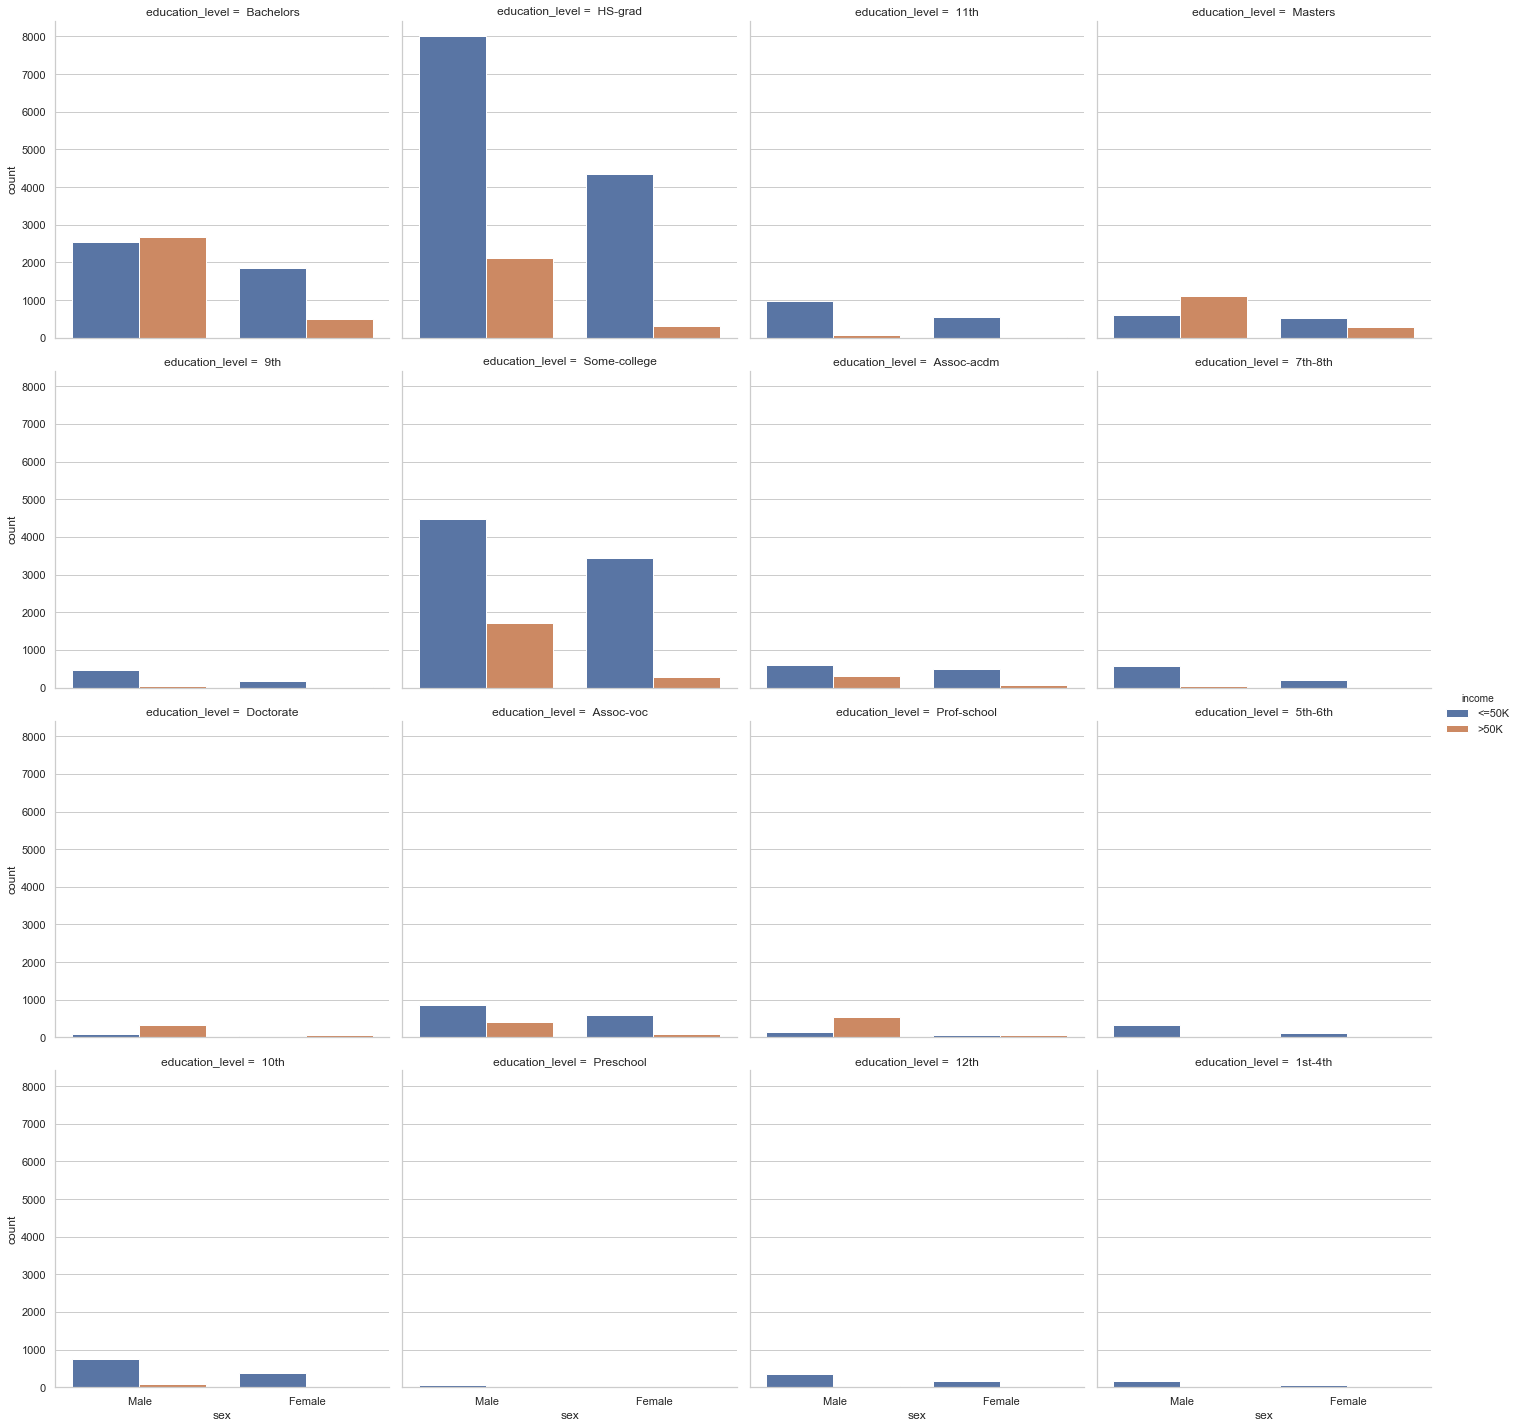

In [5]:
#Visualize the relationship between different features
sns.set(style="whitegrid", color_codes=True)
sns.factorplot("sex", col='education_level', 
               data=data, hue='income', 
               kind="count", col_wrap=4);

**Featureset Exploration**

* **age**: continuous. 
* **workclass**: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked. 
* **education**: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool. 
* **education-num**: continuous. 
* **marital-status**: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse. 
* **occupation**: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces. 
* **relationship**: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried. 
* **race**: Black, White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other. 
* **sex**: Female, Male. 
* **capital-gain**: continuous. 
* **capital-loss**: continuous. 
* **hours-per-week**: continuous. 
* **native-country**: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

----
## Preparing the Data
Before data can be used as input for machine learning algorithms, it often must be cleaned, formatted, and restructured — this is typically known as **preprocessing**. Fortunately, for this dataset, there are no invalid or missing entries we must deal with, however, there are some qualities about certain features that must be adjusted. This preprocessing can help tremendously with the outcome and predictive power of nearly all learning algorithms.

### Transforming Skewed Continuous Features
A dataset may sometimes contain at least one feature whose values tend to lie near a single number, but will also have a non-trivial number of vastly larger or smaller values than that single number.  Algorithms can be sensitive to such distributions of values and can underperform if the range is not properly normalized. With the census dataset two features fit this description: '`capital-gain'` and `'capital-loss'`. 

Run the code cell below to plot a histogram of these two features. Note the range of the values present and how they are distributed.

C:\Users\shems\Google Drive\AI Machine Learning\Udacity Introduction  to Machine Learning Nanodegree\my-project-folder\DSND_Term1-master\DSND_Term1-master\projects\p1_charityml\visuals.py:48: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


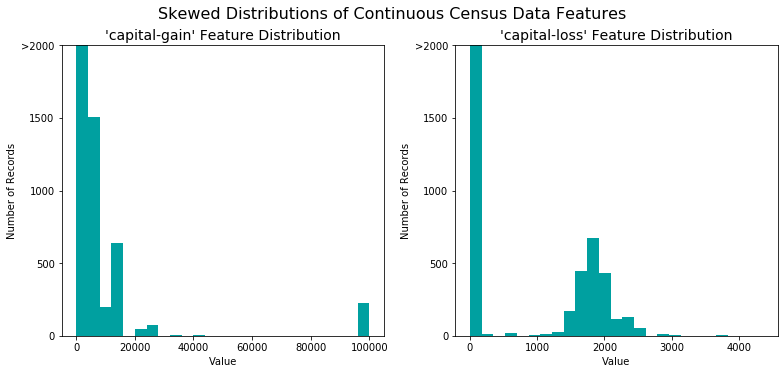

In [23]:
# Split the data into features and target label
income_raw = data['income']
features_raw = data.drop('income', axis = 1)

# Visualize skewed continuous features of original data
vs.distribution(data)

For highly-skewed feature distributions such as `'capital-gain'` and `'capital-loss'`, it is common practice to apply a <a href="https://en.wikipedia.org/wiki/Data_transformation_(statistics)">logarithmic transformation</a> on the data so that the very large and very small values do not negatively affect the performance of a learning algorithm. Using a logarithmic transformation significantly reduces the range of values caused by outliers. Care must be taken when applying this transformation however: The logarithm of `0` is undefined, so we must translate the values by a small amount above `0` to apply the the logarithm successfully.


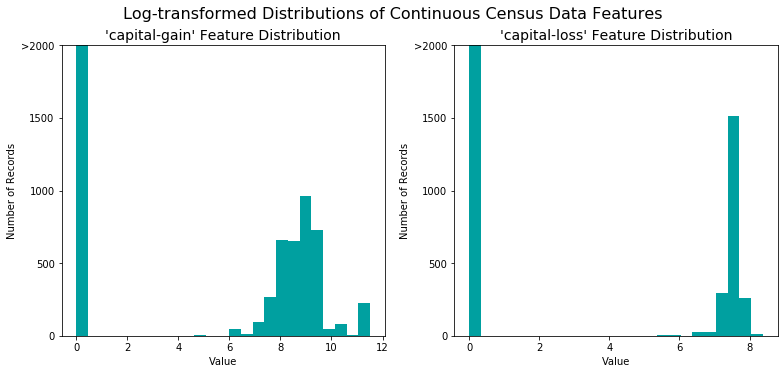

In [24]:
# Log-transform the skewed features
skewed = ['capital-gain', 'capital-loss']
features_log_transformed = pd.DataFrame(data = features_raw)
features_log_transformed[skewed] = features_raw[skewed].apply(lambda x: np.log(x + 1))

# Visualize the new log distributions
vs.distribution(features_log_transformed, transformed = True)

### Normalizing Numerical Features
In addition to performing transformations on features that are highly skewed, it is often good practice to perform some type of scaling on numerical features. Applying a scaling to the data does not change the shape of each feature's distribution (such as `'capital-gain'` or `'capital-loss'` above); however, normalization ensures that each feature is treated equally when applying supervised learners. Note that once scaling is applied, observing the data in its raw form will no longer have the same original meaning, as exampled below.


In [25]:
# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

features_log_minmax_transform = pd.DataFrame(data = features_log_transformed)
features_log_minmax_transform[numerical] = scaler.fit_transform(features_log_transformed[numerical])

# Show an example of a record with scaling applied
display(features_log_minmax_transform.head(n = 5))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.301370,State-gov,Bachelors,0.800000,Never-married,Adm-clerical,Not-in-family,White,Male,0.667492,0.0,0.397959,United-States
1,0.452055,Self-emp-not-inc,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.000000,0.0,0.122449,United-States
2,0.287671,Private,HS-grad,0.533333,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.000000,0.0,0.397959,United-States
3,0.493151,Private,11th,0.400000,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.000000,0.0,0.397959,United-States
4,0.150685,Private,Bachelors,0.800000,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.000000,0.0,0.397959,Cuba


 ### Implementation: Data Preprocessing

From the table in **Exploring the Data** above, we can see there are several features for each record that are non-numeric. Typically, learning algorithms expect input to be numeric, which requires that non-numeric features (called *categorical variables*) be converted. One popular way to convert categorical variables is by using the **one-hot encoding** scheme. 

One-hot encoding creates a _"dummy"_ variable for each possible category of each non-numeric feature. For example, assume `someFeature` has three possible entries: `A`, `B`, or `C`. We then encode this feature into `someFeature_A`, `someFeature_B` and `someFeature_C`.

|   | someFeature |                    | someFeature_A | someFeature_B | someFeature_C |
| :-: | :-: |                            | :-: | :-: | :-: |
| 0 |  B  |  | 0 | 1 | 0 |
| 1 |  C  | ----> one-hot encode ----> | 0 | 0 | 1 |
| 2 |  A  |  | 1 | 0 | 0 |

Additionally, as with the non-numeric features, we need to convert the non-numeric target label, `'income'` to numerical values for the learning algorithm to work. Since there are only two possible categories for this label ("<=50K" and ">50K"), we can avoid using one-hot encoding and simply encode these two categories as `0` and `1`, respectively.

In [26]:
# TODO: One-hot encode the 'features_log_minmax_transform' data using pandas.get_dummies()
features_final = pd.get_dummies(features_log_minmax_transform)

# TODO: Encode the 'income_raw' data to numerical values
income = data['income'].replace({"<=50K":0, 
                    ">50K":1})

# Print the number of features after one-hot encoding
encoded = list(features_final.columns)
print("{} total features after one-hot encoding.".format(len(encoded)))

# Uncomment the following line to see the encoded feature names
encoded

103 total features after one-hot encoding.


['age',
 'education-num',
 'capital-gain',
 'capital-loss',
 'hours-per-week',
 'workclass_ Federal-gov',
 'workclass_ Local-gov',
 'workclass_ Private',
 'workclass_ Self-emp-inc',
 'workclass_ Self-emp-not-inc',
 'workclass_ State-gov',
 'workclass_ Without-pay',
 'education_level_ 10th',
 'education_level_ 11th',
 'education_level_ 12th',
 'education_level_ 1st-4th',
 'education_level_ 5th-6th',
 'education_level_ 7th-8th',
 'education_level_ 9th',
 'education_level_ Assoc-acdm',
 'education_level_ Assoc-voc',
 'education_level_ Bachelors',
 'education_level_ Doctorate',
 'education_level_ HS-grad',
 'education_level_ Masters',
 'education_level_ Preschool',
 'education_level_ Prof-school',
 'education_level_ Some-college',
 'marital-status_ Divorced',
 'marital-status_ Married-AF-spouse',
 'marital-status_ Married-civ-spouse',
 'marital-status_ Married-spouse-absent',
 'marital-status_ Never-married',
 'marital-status_ Separated',
 'marital-status_ Widowed',
 'occupation_ Adm-cleri

### Shuffle and Split Data
Now all _categorical variables_ have been converted into numerical features, and all numerical features have been normalized. As always, we will now split the data (both features and their labels) into training and test sets. 80% of the data will be used for training and 20% for testing.

In [27]:
# Import train_test_split
from sklearn.model_selection import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_final, 
                                                    income, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 36177 samples.
Testing set has 9045 samples.


----
## Evaluating Model Performance
In this section, we will investigate four different algorithms, and determine which is best at modeling the data.

### Metrics and the Naive Predictor
*CharityML*, equipped with their research, knows individuals that make more than \$50,000 are most likely to donate to their charity. Because of this, *CharityML* is particularly interested in predicting who makes more than \$50,000 accurately. It would seem that using **accuracy** as a metric for evaluating a particular model's performace would be appropriate. Additionally, identifying someone that *does not* make more than \$50,000 as someone who does would be detrimental to *CharityML*, since they are looking to find individuals willing to donate. 
Therefore, a model's ability to precisely predict those that make more than \$50,000 is *more important* than the model's ability to **recall** those individuals. We can use **F-beta score** as a metric that considers both precision and recall:

$$ F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall} $$

In particular, when $\beta = 0.5$, more emphasis is placed on precision.

### Question 1 - Naive Predictor Performace
* **If we chose a model that always predicted an individual made more than $50,000, what would  that model's accuracy and F-score be on this dataset?** 

**N.b.** the the purpose of generating a naive predictor is simply to show what a base model without any intelligence would look like. In the real world, ideally your base model would be either the results of a previous model or could be based on a research paper upon which you are looking to improve. When there is no benchmark model set, getting a result better than random choice is a place you could start from.

In [28]:
'''
TP = np.sum(income) # Counting the ones as this is the naive case. Note that 'income' is the 'income_raw' data 
encoded to numerical values done in the data preprocessing step.
FP = income.count() - TP # Specific to the naive case

TN = 0 # No predicted negatives in the naive case
FN = 0 # No predicted negatives in the naive case
'''
# TODO: Calculate accuracy, precision and recall

accuracy = np.sum(income)/n_records
recall = np.sum(income)/np.sum(income)
precision = np.sum(income)/(np.sum(income) + (income.count()-np.sum(income)))

# TODO: Calculate F-score using the formula above for beta = 0.5 and correct values for precision and recall.
fscore = (1  + (0.5*0.5)) * ( precision * recall / (( 0.5*0.5 * (precision))+ recall))

# Print the results 
print("Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore))

Naive Predictor: [Accuracy score: 0.2478, F-score: 0.2917]


###  Supervised Learning Models


### Question 2 - Model Application
List three of the supervised learning models above that are appropriate for this problem that you will test on the census data. For each model chosen

- Describe one real-world application in industry where the model can be applied. 
- What are the strengths of the model; when does it perform well?
- What are the weaknesses of the model; when does it perform poorly?
- What makes this model a good candidate for the problem, given what you know about the data?

**Support Vector Machine (SVM)** 

*Real world application:*

Because the decision boundary for an SVM is entirely determined by the support vectors, their application can significantly reduce the need for labeled training instances, SVMs have proven to be helpful in text and hypertext categorization.  [SVMs](https://en.wikipedia.org/wiki/Support_vector_machine#Applications) 

Classification of images can also be performed using SVMs. Experimental results show that SVMs achieve significantly higher search accuracy than traditional query refinement schemes after just three to four rounds of relevance feedback.

*Strengths:*

A good property of SVMs is that they simultaneously minimize the empirical classification error and maximize the geometric margin [SVM Strength](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.467.8587&rep=rep1&type=pdf) 


*Weaknesses:*

SVMs are especially sensitive to the feature scales of the variables and can potentially perform poorly when feature scaling is not carried out. 
 [Hands-on Machine Learning.. Book](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/) 

Furthermore, an SVM classifier trained on an imbalanced dataset can produce suboptimal models which are biased towards the majority class and have low performance on the minority class, like most of the other classification paradigms.  [Class Imbalanced SVM Paper](http://www.cs.ox.ac.uk/people/vasile.palade/papers/Class-Imbalance-SVM.pdf)

*Candidacy for Project:*

The dataset has an imbalanced class frequency whereby the percentage of individuals making more than $50,000 makes up only 24.78% . Furthermore, the case study points towards the need for a high precision model due to the costs associated with targeting a person in the <50K class. 
There have been several techniques proposed in the literature around SVMs to make the SVM algorithm less sensitive to the class imbalance by modifying the associated kernel function. 



**Decision Trees** 

*Real world application:*

Variable selection. The number of variables that are routinely monitored in clinical settings has increased dramatically with the introduction of electronic data storage. Many of these variables are of marginal relevance and, thus, should probably not be included in data mining exercises. Decision tree methods can be used to select the most relevant input variables that should be used to form decision tree models, which can subsequently be used to formulate clinical hypotheses and inform subsequent research [Decision Trees](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4466856/) 

*Strenths:*

One of the many qualities of Decision Trees is that they require very little data preparation. In fact, they don’t require feature scaling or centering at all.  [Hands-on Machine Learning.. Book](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/) 

*Weaknesses:*

There is a high chance of overfitting the model if we build a complex model to fit the training data perfectly. 
Scikit-Learn uses the Classification and Regression Tree (CART) algorithm to train Decision Trees (also called “growing” trees). the CART algorithm is a greedy algorithm: it greedily searches for an optimum split at the top level, then repeats the process at each subsequent level. It does not check whether or not the split will lead to the lowest possible impurity several levels down. A greedy algorithm often produces a solution that’s reasonably good but not guaranteed to be optimal.
[Hands-on Machine Learning.. Book](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/) 

*Candidacy for project:*

Decision trees possess relatively high interpretability relative to other models therefore can allow us to gain important insights into the data.  [Interpretable ML Book](-	https://christophm.github.io/interpretable-ml-book/tree.html) 


**Ensemble Methods - AdaBoost** 

*Real world application:*

Change detection. This is an image analysis problem, consisting of the identification of places where the land cover has changed over time. Change detection is widely used in fields such as urban growth, forest and vegetation dynamics, land use and disaster monitoring. The earliest applications of ensemble classifiers in change detection are designed with the majority voting, Bayesian average and the maximum posterior probability -  [Ensemble Methods](https://en.wikipedia.org/wiki/Ensemble_learning#Ensemble_learning_applications) 

*Strenths:*

For classification problems, ensemble methods have proven very competitive when matched against other models (more recently in Kaggle competitions). They have often shown to produce mostly good results “out of the box” without the inconvenience of delicate and computationally expensive hyperparameter tuning.  [Ensemble Method Evaluation paper](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.467.8587&rep=rep1&type=pdf) 

*Weaknesses:*

Ensemble methods can suffer from a lack of interpretability which can be an issue if we want to identify feature importance for example. Furthermore, Ensemble methods are usually computationally expensive. [When Not to Use Ensemble Methods](https://stats.stackexchange.com/questions/158382/when-should-i-not-use-an-ensemble-classifier) 

*Candidacy for project:*

Ensemble methods, including AdaBoost can provide high quality output as a classifier allowing us to form a highly reliable classifier model. Furthermore, AdaBoost can work well despite the class imbalance in our dataset.

### Implementation - Creating a Training and Predicting Pipeline
To properly evaluate the performance of each model you've chosen, it's important that you create a training and predicting pipeline that allows you to quickly and effectively train models using various sizes of training data and perform predictions on the testing data. 

In [29]:
# TODO: Import two metrics from sklearn - fbeta_score and accuracy_score
from sklearn.metrics import fbeta_score, accuracy_score

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # TODO: Fit the learner to the training data using slicing with 'sample_size' using .fit(training_features[:], training_labels[:])
    start = time() # Get start time
    learner = learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time() # Get end time
    
    # TODO: Calculate the training time
    results['train_time'] = round(end-start, 3)
        
    # TODO: Get the predictions on the test set(X_test),
    #       then get predictions on the first 300 training samples(X_train) using .predict()
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    
    # TODO: Calculate the total prediction time
    results['pred_time'] = round(end-start,3)
            
    # TODO: Compute accuracy on the first 300 training samples which is y_train[:300]
    results['acc_train'] = accuracy_score(y_train[:300], predictions_train)
        
    # TODO: Compute accuracy on test set using accuracy_score()
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    # TODO: Compute F-score on the the first 300 training samples using fbeta_score()
    results['f_train'] = fbeta_score(y_train[:300], predictions_train, average='binary', beta=0.5)
        
    # TODO: Compute F-score on the test set which is y_test
    results['f_test'] = fbeta_score(y_test, predictions_test, average='binary', beta=0.5)
       
    # Success
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return results

### Implementation: Initial Model Evaluation
In the code cell, you will need to implement the following:
- Import the three supervised learning models you've discussed in the previous section.
- Initialize the three models and store them in `'clf_A'`, `'clf_B'`, and `'clf_C'`.
  - Use a `'random_state'` for each model you use, if provided.
  - **Note:** Use the default settings for each model — you will tune one specific model in a later section.
- Calculate the number of records equal to 1%, 10%, and 100% of the training data.
  - Store those values in `'samples_1'`, `'samples_10'`, and `'samples_100'` respectively.

**Note:** Depending on which algorithms you chose, the following implementation may take some time to run!

C:\Users\shems\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\shems\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\shems\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC trained on 361 samples.
SVC trained on 3617 samples.


C:\Users\shems\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC trained on 36177 samples.
DecisionTreeClassifier trained on 361 samples.
DecisionTreeClassifier trained on 3617 samples.
DecisionTreeClassifier trained on 36177 samples.
AdaBoostClassifier trained on 361 samples.
AdaBoostClassifier trained on 3617 samples.
AdaBoostClassifier trained on 36177 samples.


C:\Users\shems\Google Drive\AI Machine Learning\Udacity Introduction  to Machine Learning Nanodegree\my-project-folder\DSND_Term1-master\DSND_Term1-master\projects\p1_charityml\visuals.py:121: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  pl.tight_layout()


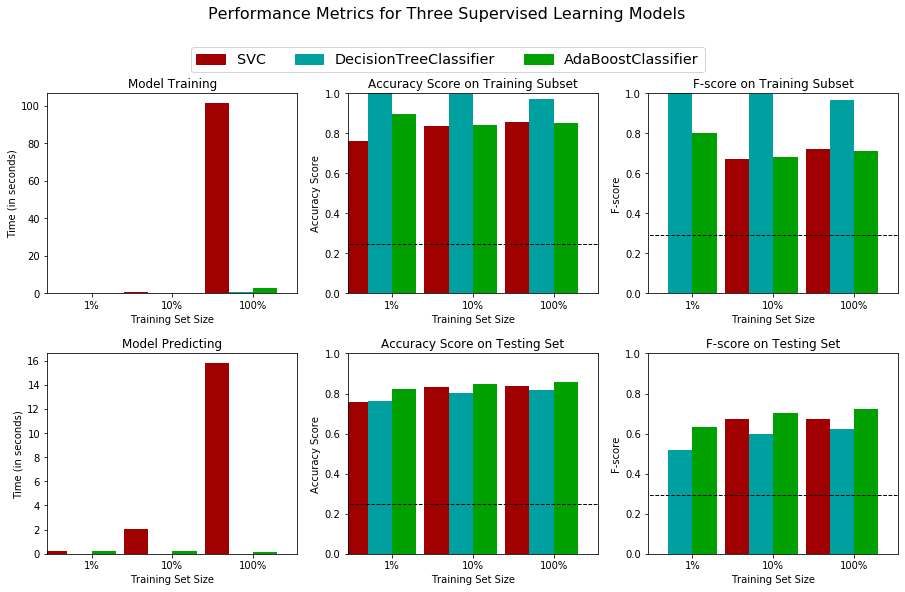

In [30]:
# TODO: Import the three supervised learning models from sklearn
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
# TODO: Initialize the three models
clf_A = SVC(random_state=101)
clf_B = DecisionTreeClassifier(random_state=101)
clf_C = AdaBoostClassifier(random_state=101)

# TODO: Calculate the number of samples for 1%, 10%, and 100% of the training data
# HINT: samples_100 is the entire training set i.e. len(y_train)
# HINT: samples_10 is 10% of samples_100 (ensure to set the count of the values to be `int` and not `float`)
# HINT: samples_1 is 1% of samples_100 (ensure to set the count of the values to be `int` and not `float`)
samples_100 = len(X_train)
samples_10 = int(0.1 * samples_100)
samples_1 = int(0.01 * samples_100)

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)

**Evaluating the Various Model Performance:**

Of the three models above, the AdaBoost Classifier is recommended as the most appropriate model to identify individuals that make more than $50,000. 

As can be seen from the metrics, when 100% of the training data is used, the AdaBoost model performs best on both accuracy and the F-score on the testing set, with the SVM coming in second. The decision tree classifier on the other hand appears to overfit the training data as its excellent performance on the 300 training data samples does not seem to generalise on the test data.

Furthermore, the AdaBoost model also takes a significantly less time to both train and prediction timing than the SVM model (the model with the second best performance metrics). 

Finally, Adaboost methods can work in the presence of both categorical and numerical data (due to its use of a decision stump of depth 1 as its base classifier), as such, the model should scale in the higher data points.

**How Ensemble Methods (& AdaBoost in particular) work in layman's terms:** 

*Ensemble Methods*
- In general terms, suppose you sent out a complex question to a forum of thousands of random people ('weak learners'), then you decide to aggregate their answers, you may very well find that the aggregated answer is better than an individual expert's answer. This product can be referred to as a strong learner, or an ensemble method, these Ensemble methods make use of the wisdom of the crowd. 

- Similarly, if you aggregate the predictions of a group of predictors, (such as classifiers as we have done above), you will often get better predictions than with the best individual predictor. 

- As an example of an Ensemble method (and the default weak learner in sklearn), you can train a group of Decision Tree classifiers, each on a different random subset of the training set. 
    - To make predictions, you obtain the predictions of all the individual trees, then predict the class that gets the most votes. 
- Boosting is a type of Ensemble method and the general idea of most boosting methods is to train predictors *sequentially*, each trying to correct its predecessor. 

*AdaBoost*

-  The most common way for a new predictor to correct its predecessor is to focus more attention to the training instances (data points) that the predecessor misclassified. 
- This results in new predictors focusing more and more on the points the previous predictor found difficult to classify as >50K in income or <=50K in income. 
    - This is the technique used in AdaBoost. 
- Once the rounds of training on the weak learning models are complete, the model is better suited to make predictions on a new data point that comes in to determine which class they fall into (>50K or <=50K). 


### Implementation: Model Tuning
Fine tune the chosen model. Use grid search (`GridSearchCV`) with at least one important parameter tuned with at least 3 different values.

In [31]:
# TODO: Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

# TODO: Initialize the classifier

clf = AdaBoostClassifier(base_estimator = DecisionTreeClassifier())

# TODO: Create the parameters list you wish to tune, using a dictionary if needed.
# HINT: parameters = {'parameter_1': [value1, value2], 'parameter_2': [value1, value2]}
parameters = { 'n_estimators':[50, 120], 
              'learning_rate':[0.1, 0.5, 1.],
              'base_estimator__min_samples_split' : [2,4,6],
              'base_estimator__max_depth' : [1,2,3]
             }

# TODO: Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score, beta=0.5)

# TODO: Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(clf, parameters, scorer)

# TODO: Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))

C:\Users\shems\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Unoptimized model
------
Accuracy score on testing data: 0.8321
F-score on testing data: 0.6570

Optimized Model
------
Final accuracy score on the testing data: 0.8702
Final F-score on the testing data: 0.7526


#### 5. Final Model Evaluation:

|     Metric     | Unoptimized Model | Optimized Model |*Benchmark predictor*|
| :------------: | :---------------: | :-------------: |:------------: | 
| Accuracy Score |  0.8364           | 0.8702          |   0.2478      |
| F-score        |  0.6657           | 0.7526          |   0.2917      |

- Relative to the benckmark predictor, both the unoptimized and optimized versions of the AdaBoost Model performed significantly better on both Accuracy Score and F-score. 
- The Optimized Model also performed better than the Unoptimized version of the model on Accuracy and F-score.


----
## Feature Importance

An important task when performing supervised learning on a dataset like the census data we study here is determining which features provide the most predictive power. By focusing on the relationship between only a few crucial features and the target label we simplify our understanding of the phenomenon, which is most always a useful thing to do. In the case of this project, that means we wish to identify a small number of features that most strongly predict whether an individual makes at most or more than \$50,000.

Choose a scikit-learn classifier (e.g., adaboost, random forests) that has a `feature_importance_` attribute, which is a function that ranks the importance of features according to the chosen classifier.  In the next python cell fit this classifier to training set and use this attribute to determine the top 5 most important features for the census dataset.

### 6. Feature Relevance Observation
When **Exploring the Data**, it was shown there are thirteen available features for each individual on record in the census data. Of these thirteen records, which five features do you believe to be most important for prediction, and in what order would you rank them and why?

**Answer:**
    
Simply speaking, the expectation would be: 
- **Education**: Generally the higher income associated jobs have a higher threshold for education levels.
- **Occupation**: Income tends to significantly change with the occupation. 
- **Hours-per-week**: Can work in two folds: 
    - Those workers whose income is directly dependent on the hours they work per week directly (hourly wage) and 
    - those that may signal higher productivity in higher demanding and therefore higher compensated jobs. 
- **Age**: Age can be a good barometer for experience which may be reflected in income.
- **Capital Gains**: Workers with higher incomes are likely to have higher disposable income to accumulate investment and therefore capital gains.

### Implementation - Extracting Feature Importance
Choose a `scikit-learn` supervised learning algorithm that has a `feature_importance_` attribute availble for it. This attribute is a function that ranks the importance of each feature when making predictions based on the chosen algorithm.

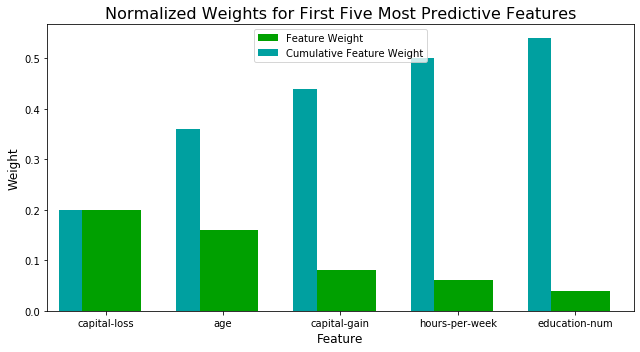

In [32]:
# TODO: Import a supervised learning model that has 'feature_importances_'
from sklearn.ensemble import AdaBoostClassifier
adaBoost = AdaBoostClassifier()
# TODO: Train the supervised model on the training set using .fit(X_train, y_train)
model = adaBoost.fit(X_train, y_train)

# TODO: Extract the feature importances using .feature_importances_ 
importances = model.feature_importances_

# Plot
vs.feature_plot(importances, X_train, y_train)

**7. Extracting Feature Importance:**

- Of the five features anticipated above, 4 of them are present: age, capital-gain, hours-per-week and education.
- One is not present and that is occupation which is slightly surprising and may be because of a preference toward numerical over categorical data by the attribute. 
- Capital-loss had the greatest weighting which I did not anticipate in my initial estimation. 
- The significant impact of age also surprised me in my initial thoughts on the order of importance. 
- Finally, the significant cumulative impact of the capital-loss and age features was overlooked in my initial thoughts.

### Feature Selection
How does a model perform if we only use a subset of all the available features in the data? With less features required to train, the expectation is that training and prediction time is much lower — at the cost of performance metrics. From the visualization above, we see that the top five most important features contribute more than half of the importance of **all** features present in the data. This hints that we can attempt to *reduce the feature space* and simplify the information required for the model to learn. The code cell below will use the same optimized model you found earlier, and train it on the same training set *with only the top five important features*. 

In [33]:
# Import functionality for cloning a model
from sklearn.base import clone

# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Train on the "best" model found from grid search earlier
clf = (clone(best_clf)).fit(X_train_reduced, y_train)

# Make new predictions
reduced_predictions = clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print("Final Model trained on full data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))
print("\nFinal Model trained on reduced data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5)))

Final Model trained on full data
------
Accuracy on testing data: 0.8702
F-score on testing data: 0.7526

Final Model trained on reduced data
------
Accuracy on testing data: 0.8437
F-score on testing data: 0.7065


**8. Effects of Feature Selection:**

- The final model on trained on full data outperformed the final model trained on reduced data in both the accuracy score (0.8702 vs 0.8437 - approx. 2.7% lower) and F-score (0.7526 vs 0.7065 - approx. 5% lower). 
- However, the difference is not highly significant given the fact that we are only using 5 of the 13 total features in the reduced data model. 
- As such, if training time alone was a factor I would consider using the reduced data system. 
- However, the final decision would also need to take into account the relative importance of accuracy vs f-score as a measure for our model. If accuracy was sufficient as a measure, for exampple if the data is not sufficiently skewed, then using the model trained on less features would be sufficient as the change in accuracy is very small. 